In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm

In [3]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA GPU is not available. Please enable GPU in Colab.")
device = torch.device("cuda")
print(f"Using device: {device}")

base_dir = "/content/drive/MyDrive/Shared Shortcuts/Arzoo_dataset_directory/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

Using device: cuda


In [4]:
batch_size = 8  # Reduced due to B7's memory usage
img_size = 300   # B7 recommended input size
epochs = 30
learning_rate = 1e-4
weight_decay = 1e-2

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes


In [6]:
model = models.efficientnet_b7(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 154MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [8]:
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 7
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val * 100

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/30: 100%|██████████| 215/215 [09:37<00:00,  2.69s/it]



Train Loss: 0.3530 | Train Acc: 82.81%
Val Loss: 0.0447 | Val Acc: 98.77%


Epoch 2/30: 100%|██████████| 215/215 [02:17<00:00,  1.57it/s]



Train Loss: 0.1389 | Train Acc: 94.58%
Val Loss: 0.0382 | Val Acc: 100.00%


Epoch 3/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0872 | Train Acc: 97.44%
Val Loss: 0.0473 | Val Acc: 98.46%


Epoch 4/30: 100%|██████████| 215/215 [02:17<00:00,  1.57it/s]



Train Loss: 0.0657 | Train Acc: 97.84%
Val Loss: 0.1715 | Val Acc: 93.52%


Epoch 5/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0717 | Train Acc: 98.48%
Val Loss: 0.0352 | Val Acc: 98.77%


Epoch 6/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0502 | Train Acc: 99.07%
Val Loss: 0.0348 | Val Acc: 99.69%


Epoch 7/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0566 | Train Acc: 98.54%
Val Loss: 0.0508 | Val Acc: 97.53%


Epoch 8/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0258 | Train Acc: 99.18%
Val Loss: 0.0172 | Val Acc: 99.69%


Epoch 9/30: 100%|██████████| 215/215 [02:17<00:00,  1.57it/s]



Train Loss: 0.0208 | Train Acc: 99.48%
Val Loss: 0.0263 | Val Acc: 98.77%


Epoch 10/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0480 | Train Acc: 98.83%
Val Loss: 0.0018 | Val Acc: 100.00%


Epoch 11/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0169 | Train Acc: 99.48%
Val Loss: 0.0566 | Val Acc: 97.84%


Epoch 12/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0216 | Train Acc: 99.24%
Val Loss: 0.0492 | Val Acc: 97.84%


Epoch 13/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0217 | Train Acc: 99.36%
Val Loss: 0.0429 | Val Acc: 98.46%


Epoch 14/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0339 | Train Acc: 98.72%
Val Loss: 0.0044 | Val Acc: 100.00%


Epoch 15/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0169 | Train Acc: 99.48%
Val Loss: 0.0067 | Val Acc: 100.00%


Epoch 16/30: 100%|██████████| 215/215 [02:16<00:00,  1.58it/s]



Train Loss: 0.0055 | Train Acc: 99.77%
Val Loss: 0.0040 | Val Acc: 100.00%


Epoch 17/30: 100%|██████████| 215/215 [02:15<00:00,  1.59it/s]



Train Loss: 0.0254 | Train Acc: 99.24%
Val Loss: 0.0014 | Val Acc: 100.00%


Epoch 18/30: 100%|██████████| 215/215 [02:15<00:00,  1.59it/s]



Train Loss: 0.0055 | Train Acc: 99.88%
Val Loss: 0.0019 | Val Acc: 100.00%


Epoch 19/30: 100%|██████████| 215/215 [02:15<00:00,  1.59it/s]



Train Loss: 0.0140 | Train Acc: 99.77%
Val Loss: 0.0007 | Val Acc: 100.00%


Epoch 20/30: 100%|██████████| 215/215 [02:15<00:00,  1.59it/s]



Train Loss: 0.0063 | Train Acc: 99.83%
Val Loss: 0.0013 | Val Acc: 100.00%


Epoch 21/30: 100%|██████████| 215/215 [02:15<00:00,  1.59it/s]



Train Loss: 0.0024 | Train Acc: 99.94%
Val Loss: 0.0360 | Val Acc: 98.46%


Epoch 22/30: 100%|██████████| 215/215 [02:15<00:00,  1.59it/s]



Train Loss: 0.0026 | Train Acc: 99.88%
Val Loss: 0.0856 | Val Acc: 96.60%


Epoch 23/30: 100%|██████████| 215/215 [02:15<00:00,  1.58it/s]



Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.0480 | Val Acc: 98.46%


Epoch 24/30: 100%|██████████| 215/215 [02:16<00:00,  1.58it/s]



Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.0736 | Val Acc: 97.53%


Epoch 25/30: 100%|██████████| 215/215 [02:16<00:00,  1.57it/s]



Train Loss: 0.0019 | Train Acc: 99.94%
Val Loss: 0.0777 | Val Acc: 97.22%


Epoch 26/30: 100%|██████████| 215/215 [02:17<00:00,  1.56it/s]



Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.0848 | Val Acc: 97.22%
Early stopping triggered.


In [9]:
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "efficientnet_b7_best.pth")
print("Best model saved as efficientnet_b7_best.pth")

Best model saved as efficientnet_b7_best.pth



Classification Report:
                   precision    recall  f1-score   support

converted_thermal     1.0000    1.0000    1.0000       162
     fake_thermal     1.0000    1.0000    1.0000       162

         accuracy                         1.0000       324
        macro avg     1.0000    1.0000    1.0000       324
     weighted avg     1.0000    1.0000    1.0000       324



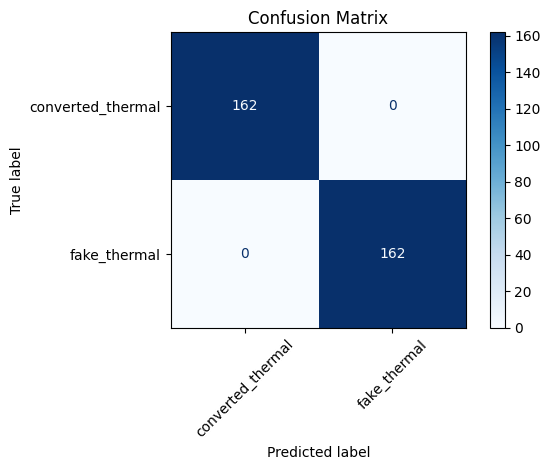

Saved: efficientnetb7_eval_results.csv and confusion_matrix_efficientnetb7.png


In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_efficientnetb7.png")
plt.show()

df = pd.DataFrame({
    "True Label": [class_names[i] for i in all_labels],
    "Predicted Label": [class_names[i] for i in all_preds]
})
df.to_csv("efficientnetb7_eval_results.csv", index=False)
print("Saved: efficientnetb7_eval_results.csv and confusion_matrix_efficientnetb7.png")
